# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [6]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: потому что возвращает вероятность попадания в положительный класс?

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [7]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


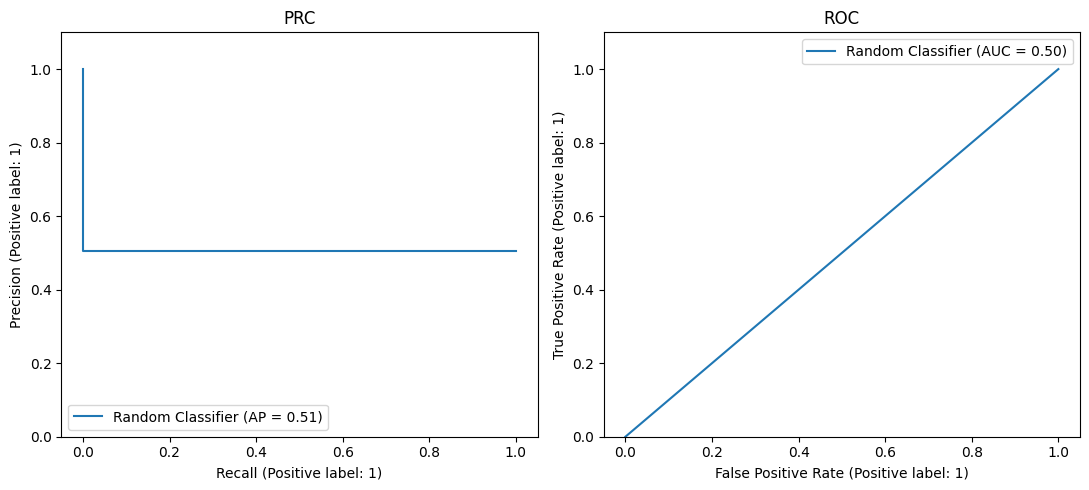

In [8]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [9]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [10]:
#your code here
from sklearn.svm import SVC

best_C = 0
best_PR_AUC = 0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

for C in np.logspace(-5, 1):
    model = SVC(C=C, kernel='linear').fit(X_train, y_train)
    
    y_p = model.predict(X_val)
    precision, recall, _ = precision_recall_curve(y_val, y_p)
    PR_AUC = auc(recall, precision)
    if best_PR_AUC < PR_AUC:
        best_PR_AUC = PR_AUC
        best_C = C

print(f"For SVC best C = {best_C} with AUC-PR = {best_PR_AUC}")

For SVC best C = 0.4498432668969444 with AUC-PR = 0.8358762225512277


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVC Classifier metrics
AUC-PR: 0.83448
AUC-ROC: 0.77618


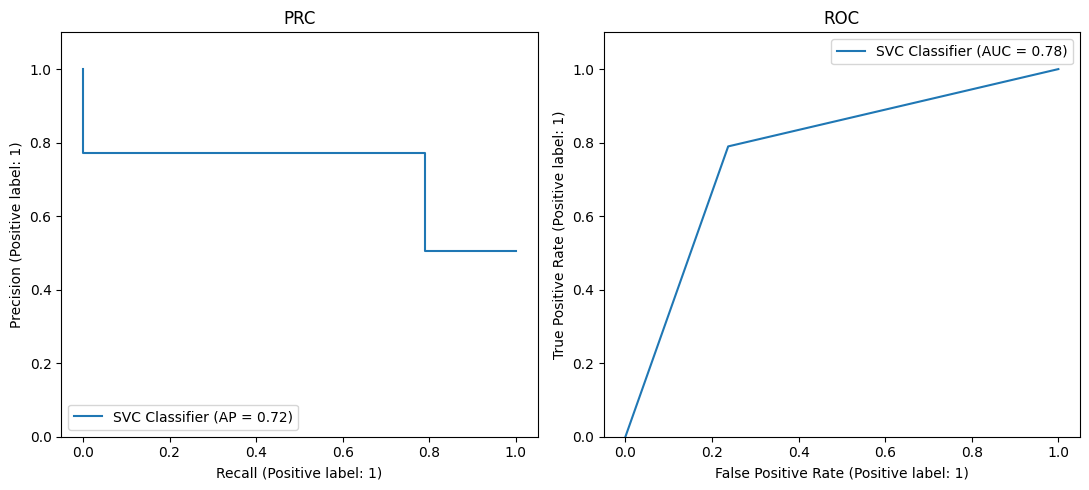

In [11]:
#your code here
y_p = SVC(C=best_C, kernel='linear').fit(X_train, y_train).predict(X_test)
depict_pr_roc(y_test, y_p, 'SVC Classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [12]:
#your code here
y_SVC = SVC(C=best_C, kernel='linear', random_state=42).fit(X_train, y_train).predict(X_test)

precision_SVC, recall_SVC, _ = precision_recall_curve(y_test, y_SVC)

df_metrics.loc['SVC'] = [
      auc(recall_SVC, precision_SVC),
      roc_auc_score(y_test, y_SVC),
      0
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.50000,0.0
SVC,0.834477,0.77618,0.0


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [13]:
#your code here
from sklearn.linear_model import LogisticRegression

best_C = 0
best_PR_AUC = 0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

for C in np.logspace(-5, 1):
    model = LogisticRegression(penalty='l2', C = C).fit(X_train, y_train)
    
    y_p = model.predict(X_val)
    precision, recall, _ = precision_recall_curve(y_val, y_p)
    PR_AUC = auc(recall, precision)
    if best_PR_AUC < PR_AUC:
        best_PR_AUC = PR_AUC
        best_C = C
        
print(f"For Logistic Regression best C = {best_C} with AUC-PR = {best_PR_AUC}")

For Logistic Regression best C = 0.2559547922699533 with AUC-PR = 0.8339252377676775


In [14]:
y_LR = LogisticRegression(penalty='l2', C = C).fit(X_train, y_train).predict(X_test)

precision_LR, recall_LR, _ = precision_recall_curve(y_test, y_LR)

df_metrics.loc['LogisticRegression'] = [
      auc(recall_LR, precision_LR),
      roc_auc_score(y_test, y_LR),
      0
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVC,0.834477,0.776180,0.0
LogisticRegression,0.832669,0.773096,0.0


Linear Classifier metrics
AUC-PR: 0.83267
AUC-ROC: 0.77310


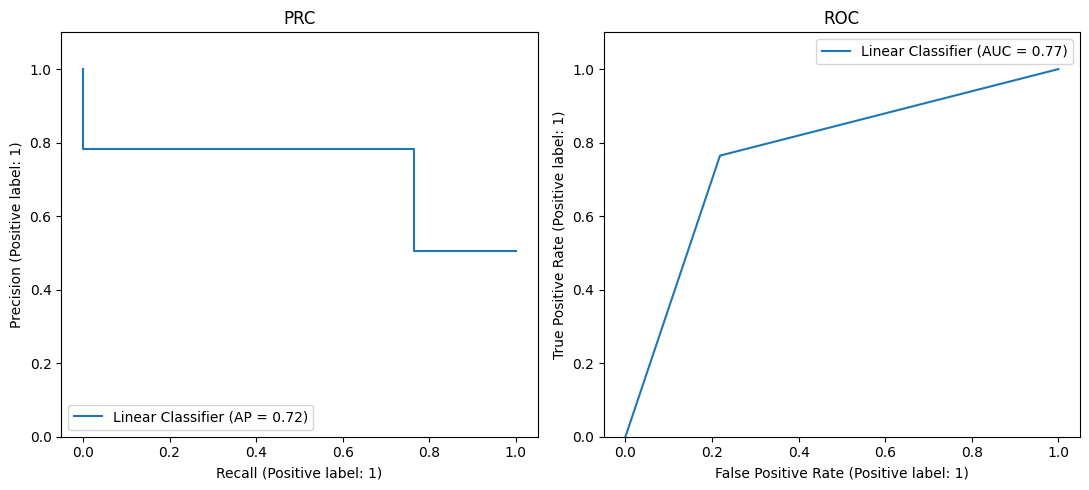

In [15]:
depict_pr_roc(y_test, y_LR, 'Linear Classifier')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

/tmp/ipykernel_3643/120926465.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([dfTo, pd.DataFrame({'classificator' : classificator, 'precision' : precision, 'recall' : recall, 'TPR': TPR, 'FPR': FPR})], ignore_index=True)


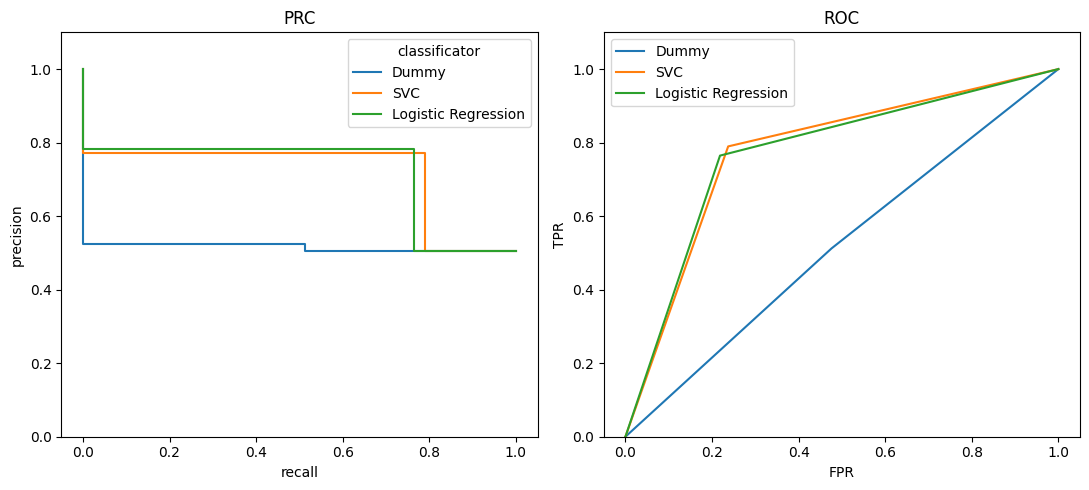

In [16]:
#your code here
from sklearn.metrics import roc_curve
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

df = pd.DataFrame(columns=['classificator', 'precision', 'recall', 'TPR', 'FPR'])

def add_data(dfTo, y_prexd, y_test, classificator):
    TPR, FPR, _ = roc_curve(y_test, y_pred, pos_label=0)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return pd.concat([dfTo, pd.DataFrame({'classificator' : classificator, 'precision' : precision, 'recall' : recall, 'TPR': TPR, 'FPR': FPR})], ignore_index=True)

y_pred = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train).predict(X_test)
df = add_data(df, y_pred, y_test, 'Dummy')

y_pred = SVC(C=0.4498432668969444, kernel='linear', random_state=42).fit(X_train, y_train).predict(X_test)
df = add_data(df, y_pred, y_test, 'SVC')

y_pred = LogisticRegression(penalty='l2', C = 0.2559547922699533, random_state=42).fit(X_train, y_train).predict(X_test)
df = add_data(df, y_pred, y_test, 'Logistic Regression')

ax[0].set_title("PRC")

ax[0].set_ylim(0, 1.1)

ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

sns.lineplot(data = df, x = 'recall', y = 'precision', drawstyle = 'steps-pre', hue = 'classificator', ax = ax[0])
sns.lineplot(data = df, x = 'FPR', y = 'TPR', hue = 'classificator', ax = ax[1])


plt.tight_layout()
plt.legend()


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** SVC & LR лучше Dummy, SVC вроде круче всех

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [17]:
#your code here
X, y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, random_state=42)
# display(X,y)

model = SVC(C=1, kernel='linear', random_state=42)


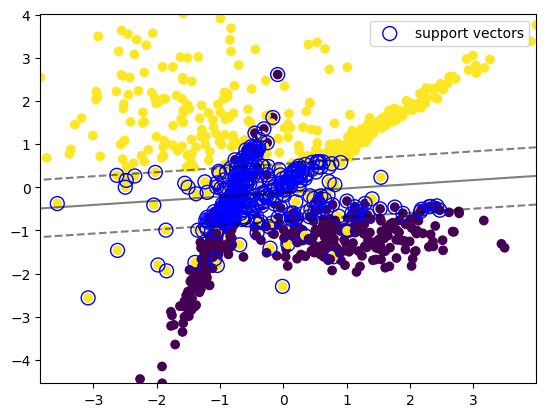

In [18]:
# помогло разобраться # https://medium.com/geekculture/svm-classification-with-sklearn-svm-svc-how-to-plot-a-decision-boundary-with-margins-in-2d-space-7232cb3962c0
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    model.fit(X, y)
    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy)
    Z = Z.reshape(XX.shape)

    
    w = model.coef_[0]
    b = model.intercept_[0]
    y_plain = -(w[0] / w[1]) * XX - b / w[1]
    
    w_hat = model.coef_[0] / (np.sqrt(np.sum(model.coef_[0] ** 2)))
    margin = 1 / np.sqrt(np.sum(model.coef_[0] ** 2))
    
    step = w_hat * margin
    
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(x=X[:,0], y=X[:, 1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(x=model.support_vectors_[:,0], y = model.support_vectors_[:,1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** неправильно определенные и неопределенные

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C = 0.2559547922699533, random_state=42)

/tmp/ipykernel_3643/1599670520.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:,0], X[:,1],


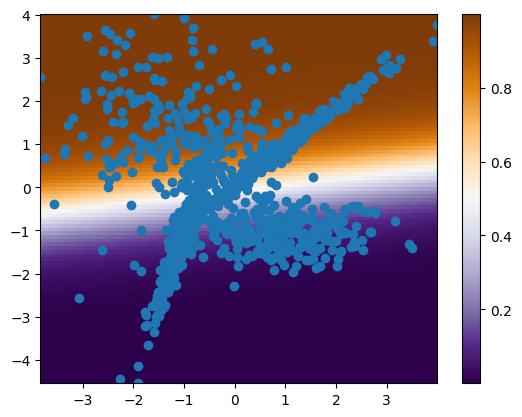

In [20]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    model.fit(X, y)

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:,0], X[:,1],
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Белая область, т.к. мы не причисляем объекты под сомнением к какому-либо классу

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [21]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        mask = (preds >= l) & (preds < r)
        bin_real_ratios.append(np.mean(y_test[mask] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [22]:
#your code here
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svc = SVC(random_state=42, probability=True).fit(X_train, y_train)
log_reg = LogisticRegression(random_state=42).fit(X_train, y_train)


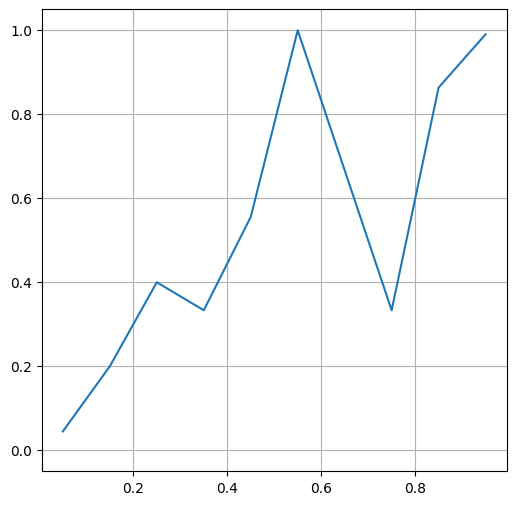

In [23]:
prediction = svc.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, prediction)

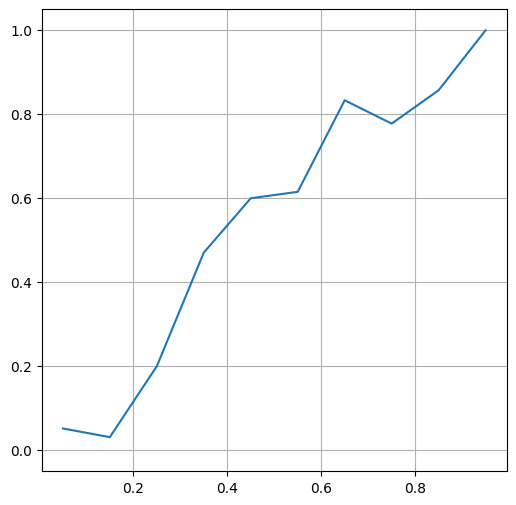

In [24]:
prediction = log_reg.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, prediction)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** #your answer here

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

(array([18., 58., 63., 15., 11.,  7., 17., 62., 39., 10.]),
 array([-1.96682708, -1.55213192, -1.13743676, -0.7227416 , -0.30804644,
         0.10664872,  0.52134388,  0.93603903,  1.35073419,  1.76542935,
         2.18012451]),
 <BarContainer object of 10 artists>)

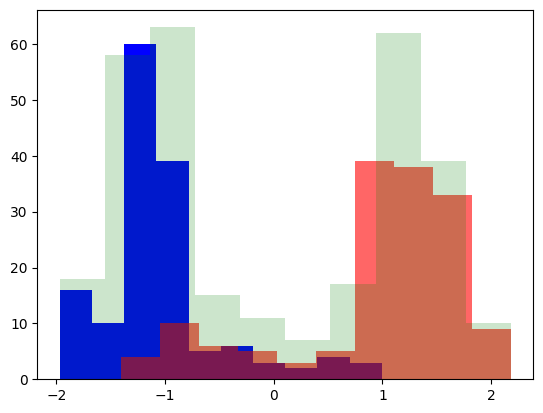

In [25]:
prediction = svc.decision_function(X_test)

plt.hist(prediction[y_test==0], color = 'b')
plt.hist(prediction[y_test==1], alpha = 0.6, color='r')
plt.hist(prediction, alpha = 0.2, color = 'g')

(array([ 5., 34., 61., 49., 38., 48., 30., 22.,  9.,  4.]),
 array([-5.68230926, -4.33271205, -2.98311484, -1.63351763, -0.28392042,
         1.0656768 ,  2.41527401,  3.76487122,  5.11446843,  6.46406564,
         7.81366285]),
 <BarContainer object of 10 artists>)

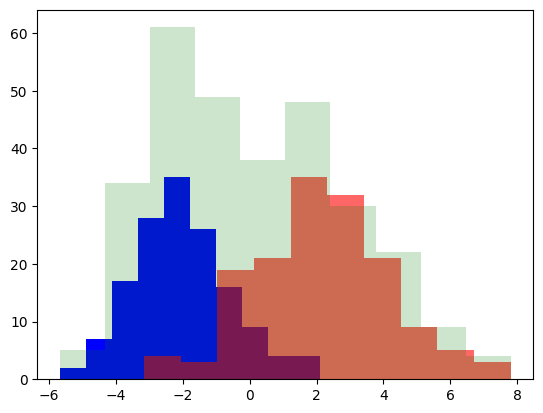

In [26]:
#your code here
prediction = log_reg.decision_function(X_test)

plt.hist(prediction[y_test==0], color = 'b')
plt.hist(prediction[y_test==1], alpha = 0.6, color='r')
plt.hist(prediction, alpha = 0.2, color = 'g')



**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** у svc ответы в среднем уверенней 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

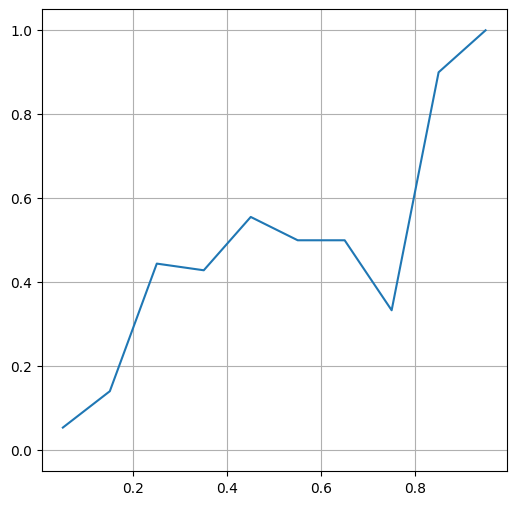

In [27]:
#your code here
from sklearn.calibration import CalibratedClassifierCV

calibrated_svc = CalibratedClassifierCV(svc).fit(X_train, y_train)
prediction = calibrated_svc.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, prediction)

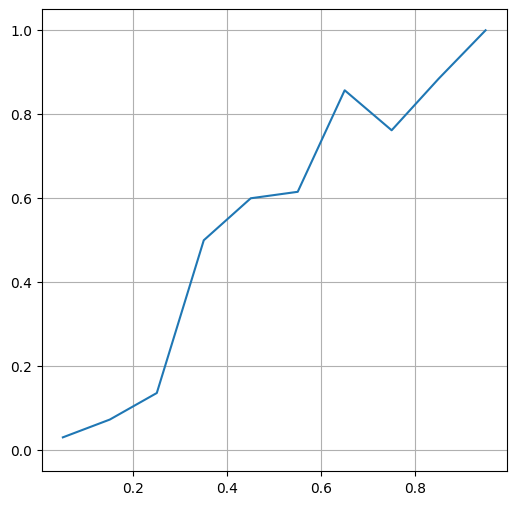

In [28]:
calibrated_svc = CalibratedClassifierCV(log_reg).fit(X_train, y_train)
prediction = calibrated_svc.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, prediction)

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да, но в скромных пределах - сгладились экстримальные точки

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [29]:
#your code here
class PlattClassifier():
    def __init__(self, Classifier):
        self.__classifier = Classifier
    
    def fit(self, X , y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.7, random_state=42)
        self.__classifier = self.__classifier.fit(X_val, y_val)
        prediction = self.__classifier.decision_function(X_train)
        self.__LogReg =  LogisticRegression(fit_intercept=True).fit(prediction.reshape(-1,1), y_train)
        return self

    def predict(self, X):
        prediction = self.__classifier.predict(X)
        return self.__LogReg.predict_proba(prediction.reshape(-1, 1))[:,1]

In [30]:
fixed_svc = PlattClassifier(SVC(probability=True)).fit(X_train, y_train)
prediction = fixed_svc.predict(X_categorical)
display(prediction)

NameError: name 'X_categorical' is not defined

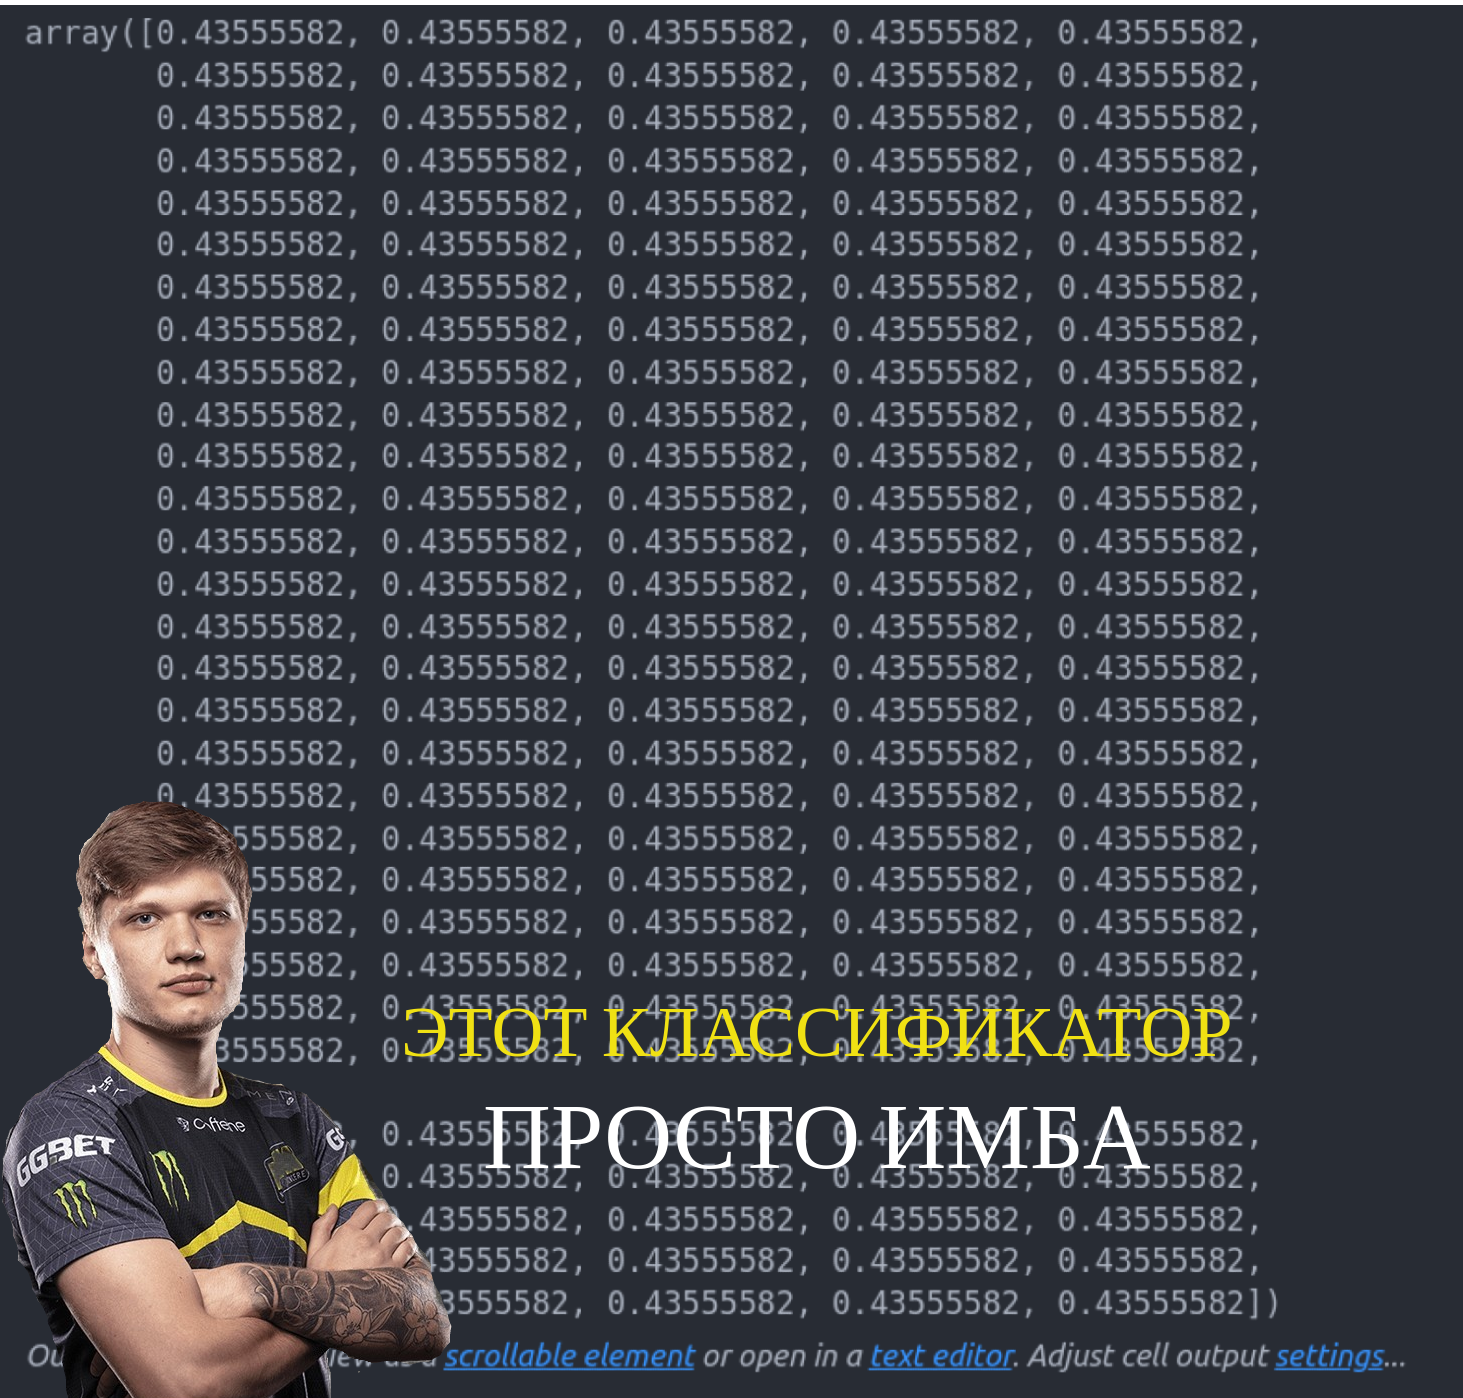

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [69]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
#your code here

X = df.drop(columns=['Purchased Bike', 'ID'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(include='number')
X_categorical = X.select_dtypes(include=['category', 'object'])

X_categorical.fillna("undefined", inplace=True)

В начале поработаем только с категориальными признаками

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [52]:
#your code here
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_recall_curve, auc
import time

statistics = pd.DataFrame(columns=["type", "time", "score"])

start = time.time()

X_categorical_OE = OrdinalEncoder().fit_transform(X_categorical)
X_train, X_test, y_train, y_test = train_test_split(X_categorical_OE, y, test_size=0.25, random_state=777, stratify=y)

log_reg = LogisticRegression('l2').fit(X_train, y_train)

learn_time = time.time() - start

y_score = log_reg.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)

statistics.loc[len(statistics)] = ['OE', learn_time, auc_precision_recall]
display(statistics)

,type,time,score
0,OE,0.050776,0.626157


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [53]:
#your code here
from sklearn.preprocessing import OneHotEncoder

start = time.time()

X_categorical_OHE = OneHotEncoder(sparse=False).fit_transform(X_categorical)
X_train, X_test, y_train, y_test = train_test_split(X_categorical_OHE, y, test_size=0.25, random_state=777, stratify=y)

log_reg = LogisticRegression('l2').fit(X_train, y_train)

learn_time = time.time() - start

y_score = log_reg.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)

statistics.loc[len(statistics)] = ['OHE', learn_time, auc_precision_recall]
display(statistics)

/home/owner/Documents/DEV/ML/ml-course-hse/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,type,time,score
0,OE,0.050776,0.626157
1,OHE,0.082532,0.704889


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [55]:
#your code here
start = time.time()
X_categorical_TE = X_categorical

for feature in X_categorical_TE.columns:
    unique_values = X_categorical_TE[feature].unique()
    for val in unique_values:
        mask = X_categorical_TE[feature] == val
        X_categorical_TE[mask] = y[mask].mean()

X_train, X_test, y_train, y_test = train_test_split(X_categorical_TE, y, test_size=0.25, random_state=777, stratify=y)

log_reg.fit(X_train, y_train)

learn_time = time.time() - start

y_score = log_reg.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)

statistics.loc[len(statistics)] = ['mean_TE', learn_time, auc_precision_recall]
display(statistics)

,type,time,score
0,OE,0.050776,0.626157
1,OHE,0.082532,0.704889
2,mean_TE,0.067414,0.613530
3,mean_TE,0.052609,0.613530


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [97]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y) -> np.ndarray:
        X_MTE = X.copy()

        for feature in X_MTE.columns:
            unique_values = X_MTE[feature].unique()
            for val in unique_values:
                mask = X[feature] == val
                X[mask] = y[mask].mean()
                
        return X_MTE
    
    def fit_transform(self, X, y) -> np.ndarray:
        return self.fit(X,y).transform(X, y)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [57]:
#your code here
best_score = 0
best_mu = 0
best_sigma = 0
best_time = 0

for mu in np.logspace(-5, 3, 20):
    for sigma in np.logspace(-5, 3, 20):
        start = time.time()
        noise = np.random.normal(mu, sigma, X_categorical_TE.shape) 
        X_TE_tmp = X_categorical_TE + noise
        
        X_train, X_test, y_train, y_test = train_test_split(X_TE_tmp, y, test_size=0.25, random_state=777, stratify=y)

        log_reg.fit(X_train, y_train)
        
        learn_time = time.time() - start
        
        y_score = log_reg.predict(X_test)

        precision, recall, _ = precision_recall_curve(y_test, y_score)
        auc_precision_recall = auc(recall, precision)
        if best_score < auc_precision_recall:
            best_score = auc_precision_recall
            best_mu = mu
            best_sigma = sigma
            best_time = learn_time

print(f"best mu = {best_mu}, best sigma = {best_sigma}")
statistics.loc[len(statistics)] = ['noised mean TE', best_time, best_score]


best mu = 54.555947811685144, best sigma = 1e-05


In [58]:
display(statistics)

,type,time,score
0,OE,0.050776,0.626157
1,OHE,0.082532,0.704889
2,mean_TE,0.067414,0.613530
3,mean_TE,0.052609,0.613530
4,noised mean TE,0.007710,0.740000


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** помогло, но пришлось начать перебирать более малые параметры распределения, чтобы наоборот не ухудшать

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
# #your code here
# 1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
# 2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам 



#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [59]:
y.value_counts()

Purchased Bike
0    519
1    481
Name: count, dtype: int64

In [60]:
#your code here
global_mean = y.mean()
print(481./(519. + 481.), global_mean)
best_C = 0
best_score = 0
best_time = 0
best_score = 0

for C in np.logspace(-10, 100, 2000):
    start = time.time()
    noise = np.random.normal(loc = 54.555947811685144, scale = 1e-05, size=X_categorical.shape) 
    X_TE_exp = X_categorical
    
    for feature in X_TE_exp.columns:
        unique_values = X_TE_exp[feature].unique()
        for val in unique_values:
            mask = X_TE_exp[feature] == val
            X_TE_exp[mask] = (y[mask].sum() + C * global_mean) / (len(X_TE_exp[mask]) + C)
    X_categorical_TE = X_categorical_TE + noise
    
    X_train, X_test, y_train, y_test = train_test_split(X_TE_exp, y, test_size=0.25, random_state=777, stratify=y)

    log_reg.fit(X_train, y_train)
    
    learn_time = time.time() - start
    
    y_score = log_reg.predict(X_test)

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    auc_precision_recall = auc(recall, precision)
    if best_score < auc_precision_recall:
        best_C = C
        best_time = learn_time
        best_score = auc_precision_recall
        

print(f"Best C = {best_C}")
statistics.loc[len(statistics)] = ['Exponential smoothing', best_time, best_score]


0.481 0.481
Best C = 1248.9592653272284


In [61]:
display(statistics)

,type,time,score
0,OE,0.050776,0.626157
1,OHE,0.082532,0.704889
2,mean_TE,0.067414,0.613530
3,mean_TE,0.052609,0.613530
4,noised mean TE,0.007710,0.740000
5,Exponential smoothing,0.029330,0.740000


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [76]:
#your code here
X_numerical.fillna(X_numerical.mean(), inplace=True)

X = pd.concat([X_categorical, X_numerical], axis = 1)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [83]:
# слишком много одного и того же кода, он даже меня задолбал
def PR_AUC_IN_LOGREG(X, y, message):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

    log_reg = LogisticRegression().fit(X_train, y_train)

    y_p = log_reg.predict(X_test)

    precision, recall, _ = precision_recall_curve(y_test, y_p)
    print(message, auc(recall, precision))


In [ ]:
for feature in X_numerical.columns:
    display(f"{feature}: {len(X_numerical[feature].unique())}")

'Income: 17'

'Children: 7'

'Cars: 6'

'Age: 54'

In [102]:
#your code here
MTE = MeanTargetEncoder()
ugly_X = MTE.fit_transform(X,y)
# ugly_X = pd.DataFrame(data = ugly_X, columns=OHE.get_feature_names_out())
PR_AUC_IN_LOGREG(ugly_X, y, "all categories encoded:")

all categories encoded: 0.6135299145299145


In [104]:
for clmn in X_numerical.columns:
    X_part = pd.concat([X_categorical, X_numerical[clmn]], axis = 1)
    X_part = MTE.fit_transform(X_part, y)
    # X_part = pd.DataFrame(data = X_part, columns=OHE.get_feature_names_out())
    PR_AUC_IN_LOGREG(X_part, y, f"with only {clmn} from numericals encoded:")

with only Income from numericals encoded: 0.74
with only Children from numericals encoded: 0.5735802469135802
with only Cars from numericals encoded: 0.6885555555555556
with only Age from numericals encoded: 0.6210714285714285


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ #your answer here

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [42]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-17 22:10:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.2’

adult.data.2            [      <=>           ]   3,79M   195KB/s    in 18s     

2023-11-17 22:11:10 (215 KB/s) - ‘adult.data.2’ saved [3974305]



In [121]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
display(df.sample())

columns.remove('income')
X = df[columns]
y = df['income']

X_numerical = X.select_dtypes(include='number')
X_categorical = X.select_dtypes(include=['category', 'object'])
print(X_categorical.shape, X_numerical.shape)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
21409,31,Private,289731,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0


(32561, 8) (32561, 6)


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [122]:
#your code here
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
OHE = OneHotEncoder(sparse=False, drop='first')
transformed = OHE.fit_transform(X_categorical)
X_categorical = pd.DataFrame(transformed, columns=OHE.get_feature_names_out())
display(X_categorical.shape)

/home/owner/Documents/DEV/ML/ml-course-hse/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(32561, 94)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [123]:
#your code here
X = pd.concat(objs = [X_numerical, X_categorical], axis = 1)
PR_AUC_IN_LOGREG(X, y, "OHE on categorical:")


OHE on categorical: 0.5682073185072054


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [124]:
#your code here
from sklearn.linear_model import LinearRegression

def get_best_features(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
    lin_model = LinearRegression()
    lin_model = lin_model.fit(X_train, y_train)
    indexes = np.argpartition(np.fabs(lin_model.coef_), -40)[-40:]
    best_features = X_train.columns[indexes]
    return best_features

get_best_features(X, y)

Index(['native-country_ Cuba', 'native-country_ Yugoslavia',
       'native-country_ Canada', 'native-country_ Cambodia', 'sex_ Male',
       'relationship_ Wife', 'relationship_ Unmarried',
       'native-country_ England', 'native-country_ France',
       'native-country_ Germany', 'relationship_ Own-child',
       'native-country_ Guatemala', 'relationship_ Other-relative',
       'native-country_ Holand-Netherlands', 'native-country_ Honduras',
       'occupation_ Tech-support', 'occupation_ Protective-serv',
       'occupation_ Prof-specialty', 'occupation_ Farming-fishing',
       'occupation_ Exec-managerial', 'native-country_ Italy',
       'occupation_ Armed-Forces', 'native-country_ Japan',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-AF-spouse', 'native-country_ Nicaragua',
       'native-country_ Outlying-US(Guam-USVI-etc)', 'education_ Prof-school',
       'native-country_ Philippines', 'education_ Preschool',
       'education_ Masters', 'e

In [125]:
X_cut = X[get_best_features(X, y)]
PR_AUC_IN_LOGREG(X_cut, y, "Lin Model determined best 40 features:")


Lin Model determined best 40 features: 0.6480491572629774


/home/owner/Documents/DEV/ML/ml-course-hse/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Изменилось ли качество? Как?
>Улучшилось, но не сильно

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?
> Ничего хорошего - качество ухудшилось

In [126]:
#your code here
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
transformed = SS.fit_transform(X_numerical)
X_numerical = pd.DataFrame(transformed, columns=SS.get_feature_names_out())

X = pd.concat(objs = [X_numerical, X_categorical], axis = 1)
X_cut = X[get_best_features(X, y)]

PR_AUC_IN_LOGREG(X_cut, y, "Lin Reg best 40 features but with scaler on numerical")

Lin Reg best 40 features but with scaler on numerical 0.5469968040119502


/home/owner/Documents/DEV/ML/ml-course-hse/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?
> КАЧЕСТВО ВЫРОСЛО, ЛОЛ

In [127]:
#your code here
transformed = SS.fit_transform(X)
X_strange = pd.DataFrame(transformed, columns=SS.get_feature_names_out())

PR_AUC_IN_LOGREG(X_strange, y, "Lin Reg best 40 with all features scaled, lol:")


Lin Reg best 40 with all features scaled, lol: 0.7184708034481659


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [134]:
#your code here
# import math
def t_stat(X, y):
    plus = (y == 1)
    mu_plus = y[plus].mean()
    mu_minus = y[~plus].mean()
    
    var_plus = y[plus].var()
    var_minus = y[~plus].var()
    
    n_plus = plus.sum()
    n_minus = ~(plus).sum()
    
    return np.fabs(mu_plus - mu_minus) / np.sqrt((n_plus*var_plus + n_minus*var_minus) / (n_plus + n_minus))


In [135]:
T = dict()
for clmn in X.columns: T[clmn] = t_stat(X[clmn], y)

top_features = sorted(T, reverse=True)[:40]
# oops, div by zero, need to check

/tmp/ipykernel_3643/3998966162.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return np.fabs(mu_plus - mu_minus) / np.sqrt((n_plus*var_plus + n_minus*var_minus) / (n_plus + n_minus))


In [136]:
X_t = X[top_features]

PR_AUC_IN_LOGREG(X_t, y, "With t-statistic's top 40:")

With t-statistic's top 40: 0.6662182335678553


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [51]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [52]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [137]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [138]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

KeyError: "['duration', 'y'] not found in axis"

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
# your code here

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here